<img src="files/logo.jpg",width=100,height=100>

<div class="alert alert-danger">
Warning: this tutorial is continually updated, Please verify the last update.
<div>

This tutorial describes how to use the SMT, which is a python toolbox for building surrogate models.

Three steps are necessary to build any type of surrogate model with SMT.
The first step consists of constructing the design of experiments (DoE), denoted by $\textbf{X}=[\textbf{x}^{(1)},\dotsc,\textbf{x}^{(n)}]$, with $n$ the number of observations.
Several types of DoE are existing in the litterature.
In this tutorial, we use the latin hypercube type based on [this package](https://pythonhosted.org/pyDOE/).
The second step consists of evaluating $\textbf{X}$ using the true function $y$.
The outputs of $\textbf{X}$ will be denoted by $\textbf{y}$.
The final step consists of building the surrogate model through the estimation of its parameters.

<div class=alert>
$\textit{In the following, the user needs to run each cell (using the 'ipynb' file) which starts by the comment}$ # Run by the user.
<div/>

After installing the SMT, please add the path of the toolbox for running this tutorial.

In [1]:
# Run by the user
import warnings
import sys
try:
    # Add the path of the toolbox
    sys.path.append("/home/mbouhlel/hg/SMT/") # Fill by the user
    sys.path.append("../examples")
    import smt
except:
    warnings.warn("The SMT's path is wrong, the code will not work.")

# 1. Construction and evaluation of the DoE

To achieve the two first steps in the surrogate model construction, we use the scripts---"doe_lhs.py", "tools_doe" and "tools_benchmark.py"---located in ".../SMT/examples" for the construction and evaluation of the DoE.
For this tutorial, we build a surrogate model based on data from an analytical function, $y$ given by
\begin{equation}
y = \sum\limits_{i=1}^{\text{dim}}x_i^2,
\end{equation}
with $\text{dim} = 10$, $n=10\text{dim}$ and a number of validation points $n_{\text{test}}=500$.

In [2]:
# Run by the user
from __future__ import division
import numpy as np
import tools_benchmark as fun
from tools_doe import  trans
import doe_lhs

# Initialization of the problem
dim = 10
ndoe = 10*dim

# Upper and lower bounds of the problem
xlimits = np.zeros((dim, 2))
xlimits[:, 0] = -10
xlimits[:, 1] = 10

# Construction of the DOE in [0,1]
xt = doe_lhs.lhs(dim,ndoe,'cm')

# Transform the DoE in [LB,UB]
xt = trans(xt,xlimits[:, 0],xlimits[:, 1])

# Compute the output (+ the gradient if available, otherwise yd is {})
yt,yd = fun.carre(xt)

# Construction of the validation points
ntest = 500
xtest = doe_lhs.lhs(dim, ntest)
xtest = trans(xtest,xlimits[:, 0],xlimits[:, 1])
ytest,ydtest = fun.carre(xtest)

We have so far constructed the training (xt,yt) and validating (xtest,ytest) points.

# 2. Building a surrogate model from the SMT

## 2.1. Main functions

For using any surrogate model with SMT, we first need to import the surrogate model that we want to use

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Import a model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; from smt.model import MODEL

We import the surrogate model (MODEL, in uppercase) with the module model (model, in lowercase).

Then, we initialize the surrogate model using two dictionaries to define the parameters of the model

* Dictionary of the model-options: set up the parameters related to the surrogate model.
This list of parameters is different for each surrogate model

* Dictionary of the print-options: set up the print-parameters related to the surrogate model.
This list of parameters is the same for each surrogate model

Four parameters are always used in the "Dictionary of the print-options" for all models

* 'global':bool --> not display any time-information if False, default: True

* 'problem':bool --> display the problem information, default: True

* 'time_eval':bool --> display the time to evaluate xtest, default: True

* 'time_train':bool --> display the time to train the model, default: True

The initialization should be

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Initialization of the model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; t = MODEL({Dictionary of the model-options},{Dictionary of the print-options})

Then, we add the training points into the surrogate model and the gradient values if available

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Add the training points

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; t.add training pts('exact',xt,yt)

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Add the gradient information if available

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; for i in xrange(dim):

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  t.add training pts('exact',xt,yd[:, i],kx=i)
    
Next, we build the surrogate model through the "train" method

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Train the model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; t.train()

Finally, we predict the output of the unknown points through the surrogate model

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; # Prediction of xtest

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; y = t.predict(xtest)

## 2.2. Examples 

### 2.2.1. The least square model

The first model used in this tutorial is the least square model (LS).
No parameters are needed for running this model

In [3]:
# Run by the user
from smt.ls import LS
t = LS({},{})
t.add_training_pts('exact',xt,yt)
t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                    LS
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.0026860 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0000479 
   Time/pt. (sec) :  0.0000001 



We compute the relative error (RE) 
\begin{equation}
\text{RE} = \frac{\sqrt{\sum\limits_{i=1}^{n_\text{test}}\left(y\left(\textbf{x}_{\text{test}}\right)-\hat{y}\left(\textbf{x}_{\text{test}}\right)\right)^2}}{\sqrt{\sum\limits_{i=1}^{n_{\text{test}}}\left(y\left(\textbf{x}_{\text{test}}\right)\right)^2}}100,
\end{equation}


In [4]:
# Run by the user
from scipy import linalg
print 'LS,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
            ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
            ytest.reshape((ntest,1)))**2)*100)


LS,  err: 29.28017115


We plot the results. The x-axis represents the true values of the validation outputs, the y-axis represents the prediction values of the validation outputs

/home/mbouhlel/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


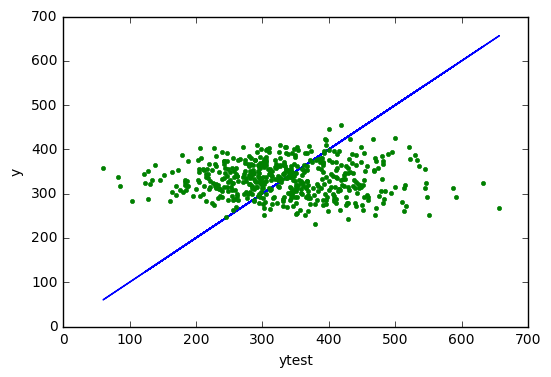

In [5]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

### 2.2.2. The square polynomial approach

The second model used in this tutorial is the square polynomial approach (PA2).
No parameters are needed for running this model

In [6]:
# Run by the user
from smt.pa2 import PA2
t = PA2({},{})
t.add_training_pts('exact',xt,yt)
t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                    PA2
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.0020990 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0002820 
   Time/pt. (sec) :  0.0000006 



We compute the relative error (RE)

In [7]:
# Run by the user
from scipy import linalg
print 'PA2,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
            ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
            ytest.reshape((ntest,1)))**2)*100)


PA2,  err: 5.64715672178e-12


We plot the results: the x-axis represents the true values of the validation outputs, the y-axis represents the prediction values of the validation outputs.

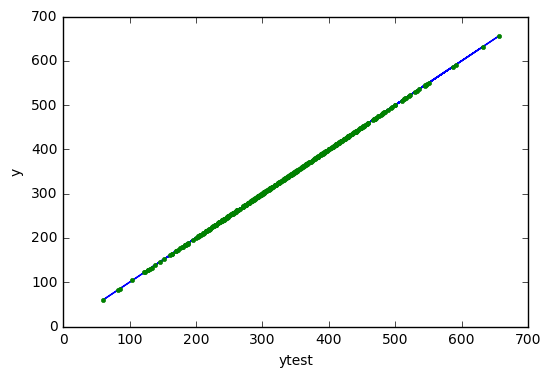

In [8]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

### 2.2.3. The kriging-based models

The "kpls.py" module permits the construction of 4 different models, among the kriging-based models.
Indeed, following some simple rules on the use of the parameters related to the model, we could construct the classic (ordinary or universal) kriging, KPLS, KPLSK and GEKPLS models.

#### 2.2.3.1 The classic kriging model

For using the kriging model, the user needs to provide few parameters in the 'Dictionary of the model-options'

* 'name': 'KRG'

* 'n_comp': dim, n_comp is the number of principal components. n_comp must be equal to dim for using the kriging model

* 'theta0': [1e-2]*dim, theta0 is a list of length dim, containing the starting point for the hyperparameters optimization

* 'poly' : 'constant', poly is a string among ['constant','linear','quadratic'], default: 'constant'.

* 'corr' :  'squar_exp', corr is a string among ['abs_exp','squar_exp'], default: 'squar_exp'

Let us run an ordinary kriging model on our example

In [9]:
# Run by the user
from smt.kpls import KPLS
t = KPLS({'name':'KRG','n_comp':dim,'theta0': [1e-2]*dim},{})
t.add_training_pts('exact',xt,yt)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                    KRG
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.0748351 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0058281 
   Time/pt. (sec) :  0.0000117 



We compute the relative error (RE)

In [10]:
from scipy import linalg
print 'ordinary Kriging,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
                 ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
                 ytest.reshape((ntest,1)))**2)*100)

ordinary Kriging,  err: 0.874040468135


We plot the result: the x-axis contains the true values of the validation outputs, the y-axis contains the prediction values of the validation outputs.

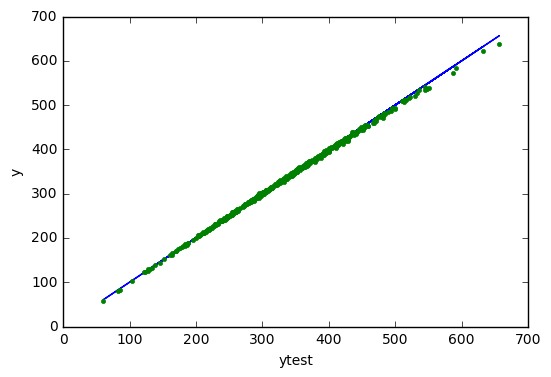

In [11]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

Let us now run a kriging model with a quadratic regression term

In [12]:
# Run by the user
t = KPLS({'name':'KRG','n_comp':dim,'theta0': [1e-2]*dim,'poly':'quadratic'},{})
t.add_training_pts('exact',xt,yt)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                    KRG
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.1053901 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0059819 
   Time/pt. (sec) :  0.0000120 



We compute the relative error (RE)

In [13]:
from scipy import linalg
print 'Kriging,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
                 ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
                 ytest.reshape((ntest,1)))**2)*100)

Kriging,  err: 6.89210266522e-14


We plot the result

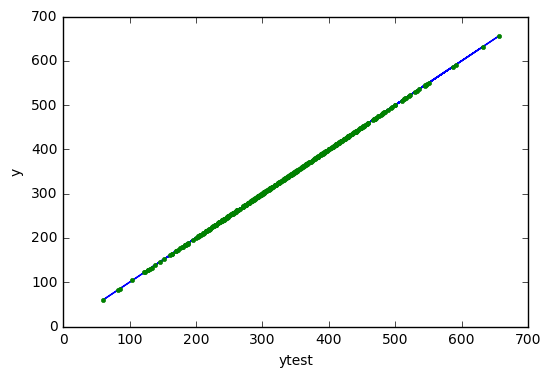

In [14]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

We can similarly proceed with the parmaters 'corr' and 'poly' for the other models.

#### 2.2.3.2 The KPLS model

For using the KPLS model, the user should provide few parameters in the 'Dictionary of the model-options'

* 'name': 'KPLS'

* 'n_comp': 4, n_comp is the number of principal components. n_comp must be equal to dim for using the kriging model

* 'theta0': [1e-2]*4, theta0 is a list of length n_comp, containing the starting point for the hyperparameters optimization

* 'poly' : 'constant', poly is a string among ['constant','linear','quadratic'], default: 'constant'.

* 'corr' :  'squar_exp', corr is a string among ['abs_exp','squar_exp'], default: 'squar_exp'

In [15]:
# Run by the user
from smt.kpls import KPLS
t = KPLS({'name':'KPLS','n_comp':4,'theta0': 4*[1e-2]},{})
t.add_training_pts('exact',xt,yt)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                   KPLS
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.0336130 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0062790 
   Time/pt. (sec) :  0.0000126 



We compute the relative error (RE)

In [16]:
from scipy import linalg
print 'KPLS,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
              ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
              ytest.reshape((ntest,1)))**2)*100)

KPLS,  err: 14.219610556


We plot the result

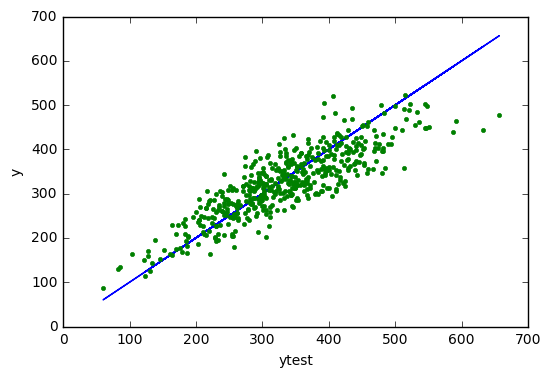

In [17]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

#### 2.2.3.3 The KPLSK model

Compared to the KPLS model, the user only needs to modify the parameter

* 'name': 'KPLSK'

In [18]:
# Run by the user
from smt.kpls import KPLS
t = KPLS({'name':'KPLSK','n_comp':4,'theta0': 4*[1e-2]},{})
t.add_training_pts('exact',xt,yt)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                   KPLSK
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.0575371 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0059631 
   Time/pt. (sec) :  0.0000119 



We compute the relative error (RE)

In [19]:
from scipy import linalg
print 'KPLSK,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
              ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
              ytest.reshape((ntest,1)))**2)*100)

KPLSK,  err: 12.1206602539


We plot the result

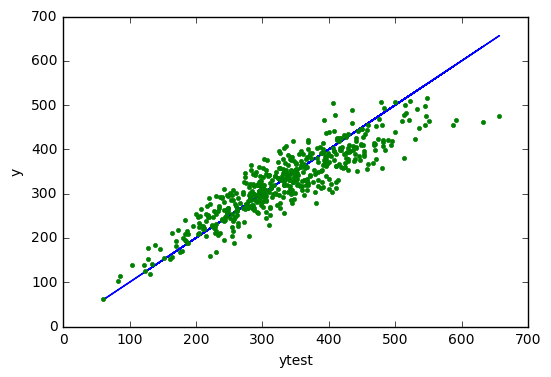

In [20]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

#### 2.2.3.4 The GEKPLS model

Contrarily to what we have seen with the previous models, the GEKPLS model needs the gradient information.
Therefore, few additional parameters should be defined by the user

* 'name': 'GEKPLS'

* 'delta_x': 1e-4,   # Step used in the first order Taylor approach, default: 1e-4

* 'xlimits': None,   # upper and lower variables bounds, default: None

* 'extra_pts': 0,    # Number of extra points per each training point, default: 0

In the following, an example of a GEKPLS construction without extra approximated points 

In [21]:
# Run by the user
from smt.kpls import KPLS
t = KPLS({'name':'GEKPLS','n_comp':2,'theta0': [1e-2,1e-2],'xlimits':xlimits},{})
t.add_training_pts('exact',xt,yt)
# Add the gradient information
for i in xrange(dim):
    t.add_training_pts('exact',xt,yd[:, i].reshape((yt.shape[0],1)),kx=i)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                  GEKPLS
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Training


   Total (sec)    :  0.0642622 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0054531 
   Time/pt. (sec) :  0.0000109 



We compute the relative error (RE)

In [22]:
from scipy import linalg
print 'GEKPLS,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
                ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
                ytest.reshape((ntest,1)))**2)*100)

GEKPLS,  err: 0.000446974210262


We plot the result

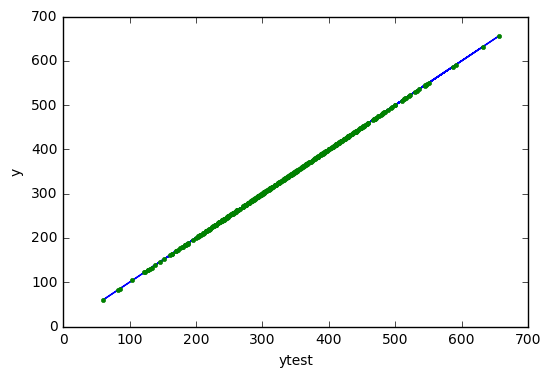

In [23]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

Let us see an example of a GEKPLS construction witht 1 extra approximated point

In [24]:
t = KPLS({'name':'GEKPLS','n_comp':2,'theta0': [1e-2,1e-2],'xlimits':xlimits,'extra_pts':2},{})
t.add_training_pts('exact',xt,yt)
# Add the gradient information
for i in xrange(dim):
    t.add_training_pts('exact',xt,yd[:, i].reshape((yt.shape[0],1)),kx=i)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                  GEKPLS
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

fmin_cobyla failed but the best value is retained
___________________________________________________________________________

 Training


   Total (sec)    :  0.1674950 

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0155962 
   Time/pt. (sec) :  0.0000312 



We compute the relative error (RE)

In [25]:
from scipy import linalg
print 'GEKPLS,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
                ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
                ytest.reshape((ntest,1)))**2)*100)

GEKPLS,  err: 0.496413514751


We plot the result

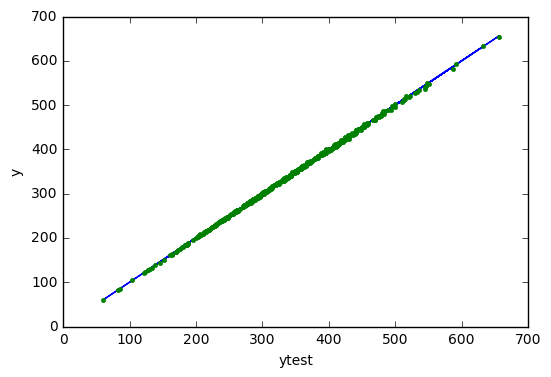

In [26]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

# 2.2.4. The inverse distance weighting

The inverse distance weighting (idw) is available only with Linux.
The parameters which should be provided by the user

* 'name': 'IDW'

* 'p': 2.5,   # Parameter p designing the power, default: 2.5


In [29]:
# Run by the user
from smt.idw import IDW
t = IDW({'name':'IDW'},{})
t.add_training_pts('exact',xt,yt)

t.train()
y = t.predict(xtest)

___________________________________________________________________________

                                    IDW
___________________________________________________________________________

 Problem size

   # training pts. (exact)   : 100

___________________________________________________________________________

 Evaluation

   # eval pts.  : 500

   Total (sec)    :  0.0048192 
   Time/pt. (sec) :  0.0000096 



We compute the relative error (RE)

In [30]:
from scipy import linalg
print 'IDW,  err: '+str(np.sqrt(1/ntest*linalg.norm(y.reshape((ntest,1))-
                ytest.reshape((ntest,1)))**2)/np.sqrt(1/ntest*linalg.norm(
                ytest.reshape((ntest,1)))**2)*100)

IDW,  err: 26.4813495179


We plot the result

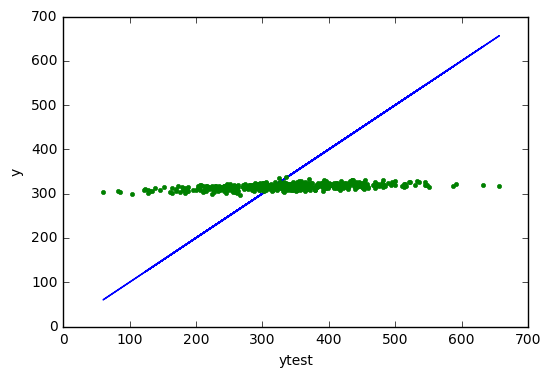

In [31]:
# Run by the user
import matplotlib.pyplot as plt
plt.figure()
plt.plot(ytest,ytest)
plt.plot(ytest,y,'.')
plt.xlabel('ytest')
plt.ylabel('y')
plt.show()

###### Last update November 16, 2016